/var/folders/yd/1x7_wd1n09z59ds7530ypvr00000gn/T/ipykernel_9981/1764106027.py:48: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx))


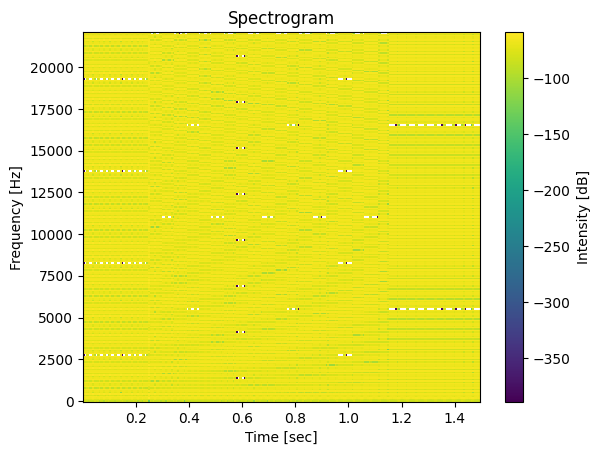

In [31]:
import numpy as np
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Set parameters
Fs = 44100
sig = np.zeros(int(1.5 * Fs))
pitchStart = 220
pitchStartSamps = round(Fs / pitchStart)
pitchFinal = 200
pitchFinalSamps = round(Fs / pitchFinal)
repeat = 10
repetition = 1 / repeat
pitchChange = np.floor(np.arange(pitchStartSamps + 1, pitchFinalSamps, repetition)).astype(int)

# Create the initial impulses
for i in range(0, Fs // 4, pitchStartSamps):
    sig[i] = 1

# Set the impulse at Fs/4
index = Fs // 4
sig[index] = 1

# Create the varying pitch impulses
for change in pitchChange:
    index += change
    if index < len(sig):
        sig[index] = 1
    else:
        break

# Fill in the remaining samples with final pitch
currIndex = index
while currIndex < len(sig):
    currIndex += pitchFinalSamps
    if currIndex < len(sig):
        sig[currIndex] = 1

# Normalize signal
sig = 0.99 * sig

# Save audio file
wavfile.write('PitchGlideImpulseTrain200_200.wav', Fs, sig.astype(np.float32))

# Generate spectrogram
f, t, Sxx = spectrogram(sig, Fs, nperseg=512, noverlap=256)
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()


In [24]:
import numpy as np
from scipy.signal import lfilter, iirfilter
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import os

def generate_impulse_train(frequency, length, sample_rate):
    period = sample_rate // frequency
    impulse_train = np.zeros(length)
    impulse_train[::period] = 1.0
    return impulse_train

def generate_white_noise(length):
    return np.random.normal(0, 1, length)

def design_filter(formants, bandwidths, sample_rate):
    b, a = 1, 1
    for f, bw in zip(formants, bandwidths):
        b_i, a_i = iirfilter(2, [f - bw / 2, f + bw / 2],
                             rs=60, btype='band', 
                             analog=False, ftype='butter', fs=sample_rate)
        b, a = np.convolve(b, b_i), np.convolve(a, a_i)
    return b, a

def synthesize_vowel(formants, bandwidths, sample_rate=44100, duration=1):
    impulse_train = generate_impulse_train(120, duration * sample_rate, sample_rate)
    b, a = design_filter(formants, bandwidths, sample_rate)
    vowel_sound = lfilter(b, a, impulse_train)
    return vowel_sound

def synthesize_consonant(formants, bandwidths, sample_rate=44100, duration=1):
    noise = generate_white_noise(duration * sample_rate)
    b, a = design_filter(formants, bandwidths, sample_rate)
    consonant_sound = lfilter(b, a, noise)
    return consonant_sound

def save_wav(sound, filename, sample_rate=44100):
    write(filename, sample_rate, np.int16(sound / np.max(np.abs(sound)) * 32767))

# Define the sample rate and formants for different vowels
sample_rate = 44100
vowels = {
    'a': ([800, 1150, 2900], [70, 110, 120]),
    'e': ([400, 1700, 2600], [60, 90, 120]),
    'i': ([350, 1700, 2700], [50, 100, 120]),
    'o': ([450, 800, 2830], [70, 80, 100]),
    'u': ([325, 700, 2530], [50, 60, 170])
}

output_path = 'output'
if not os.path.exists(output_path):
    os.mkdir(output_path)


# Synthesize vowels and consonants, and save them
for vowel, (formants, bandwidths) in vowels.items():
    vowel_sound = synthesize_vowel(formants, bandwidths, sample_rate)
    consonant_sound = synthesize_consonant(formants, bandwidths, sample_rate)
    save_wav(vowel_sound, os.path.join(output_path, f'{vowel}_vowel.wav'))
    save_wav(consonant_sound, os.path.join(output_path,f'{vowel}_consonant.wav'))
